In [1]:
import pandas as pd
import numpy as np
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
import matplotlib.pyplot as plt

# Light Prepocessing

In [2]:
df = pd.read_csv("DPD__911_Calls_for_Service_DPD__911_Calls_for_Service.csv") # reading csv file

# changing categorical data to numerical
df["officerinitiated"][df["officerinitiated"] == "Y"] = 1
df["officerinitiated"][df["officerinitiated"] == "N"] = 0
df["officerinitiated"] = df["officerinitiated"].astype(int)

# extracting latitude and longitude from the location
df["lat,lon"] = df["location"].apply(lambda x: x[x.find("("):] )
df["lat"] = df["lat,lon"].apply(lambda x : x[1:x.find(",")])
df["lon"] = df["lat,lon"].apply(lambda x : x[x.find(",")+1:-1])
df["lat"] = df["lat"].astype(float)
df["lon"] = df["lon"].astype(float)
df["lat,lon"] = list(zip(df.lat, df.lon))

# Looking up the zipcode based on the latitude and longitude and saving the preprocessed dataset
'''
search = SearchEngine()
#df["zip_info"] = df["lat,lon"].apply(lambda x : search.by_coordinates(x[0],x[1]) )
#df.to_csv("withzip_info.csv")

for count in range(len(df["zip_info"])):
    print(count,len(df))
    i = df["zip_info"][count]
    for j in i:
        if j.major_city == 'Detroit':
            df["zip"][count] = j.zipcode
            break
#df[['callno', 'agency', 'priority', 'incident_address', 'callcode',
       #'calldescription', 'category', 'calldate', 'calltime', 'disposition',
       #'precinctSCA', 'respondingunit', 'officerinitiated', 'intaketime',
       #'dispatchtime', 'traveltime', 'totresponsetime', 'timeonscene',
       #'totaltime', 'location', 'lat', 'lon', 'zip']].to_csv("final_csv.csv")
'''
None

/home/elarbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/elarbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
df = pd.read_csv("final_csv.csv") #loading the preprocessed data

# number of call occurences per category sorted by occurences in descending order
category_count = dict(zip(np.unique(df["calldescription"].values,return_counts=1)[0],np.unique(df["calldescription"].values,return_counts=1)[1]) )              
category_count = dict(sorted(category_count.items() , key = lambda x:x[1], reverse=1))

# number of call occurences per zipcode sorted by occurences in descending order
zip_count = dict(zip(np.unique(df["zip"].dropna().values,return_counts=1)[0],np.unique(df["zip"].dropna().values,return_counts=1)[1]))  
zip_count = dict(sorted(zip_count.items() , key = lambda x:x[1], reverse=1))

# average total time needed for each category
category_avgtime = df.groupby("calldescription").mean()[["totaltime"]].loc[category_count.keys()]
category_avgtime = category_avgtime.rename(columns={"totaltime":"averagetime"})
category_avgtime["count"] = category_count.values()

# average total time needed for each zipcode
zip_avgtime_adj = df[ (df.category != 'PRANK/OTHER').values & (df.category != 'HANG UP/PRANKS' ).values ].groupby("zip").mean()[["totaltime"]].rename(columns={"totaltime":"averagetime_adjusted"})              
zip_avgtime = df.groupby("zip").mean()[["totaltime"]].loc[zip_count.keys()]
zip_avgtime = zip_avgtime.rename(columns={"totaltime":"averagetime"})
zip_avgtime["count"] = zip_count.values()
zip_avgtime = zip_avgtime.join(zip_avgtime_adj).replace(np.nan,0)

# number of times officer was initiated for a call per category
officer_initiated_cat = df.groupby("calldescription").sum()[["officerinitiated"]].loc[category_count.keys()]
officer_initiated_cat["total calls"] =category_count.values()
officer_initiated_cat["diff"] = officer_initiated_cat["total calls"] - officer_initiated_cat["officerinitiated"]

# prank calls per zip code
prank_zip = df[ (df.category == 'PRANK/OTHER').values | (df.category == 'HANG UP/PRANKS' ).values ].groupby('zip').count()[["Unnamed: 0"]]
prank_zip = prank_zip.rename(columns={"Unnamed: 0":"pranks"})
prank_zip.loc[zip_count.keys(),'totalcalls'] = np.array(list(zip_count.values()))

# number of times officer was initiated for a call per zipcode
officer_initiated_zip = df.groupby("zip").sum()[["officerinitiated"]].loc[zip_count.keys()]
officer_initiated_zip["total calls"] =zip_count.values()
officer_initiated_zip["diff"] = officer_initiated_zip["total calls"] - officer_initiated_zip["officerinitiated"]
officer_initiated_zip = officer_initiated_zip.join(prank_zip[["pranks"]]).replace(np.nan,0)
officer_initiated_zip["diff_adjusted"] = officer_initiated_zip["diff"] - officer_initiated_zip["pranks"]



# calls per hour
df["calltime"] = df["calltime"].apply(lambda x : x[:x.find(":")] + x[-2:])
hours = df.groupby("calltime").mean()[["totaltime"]]
hours = hours.rename(columns={"totaltime":"averagetime"})

In [5]:
plt.rcdefaults()
plt.style.use('seaborn-pastel')

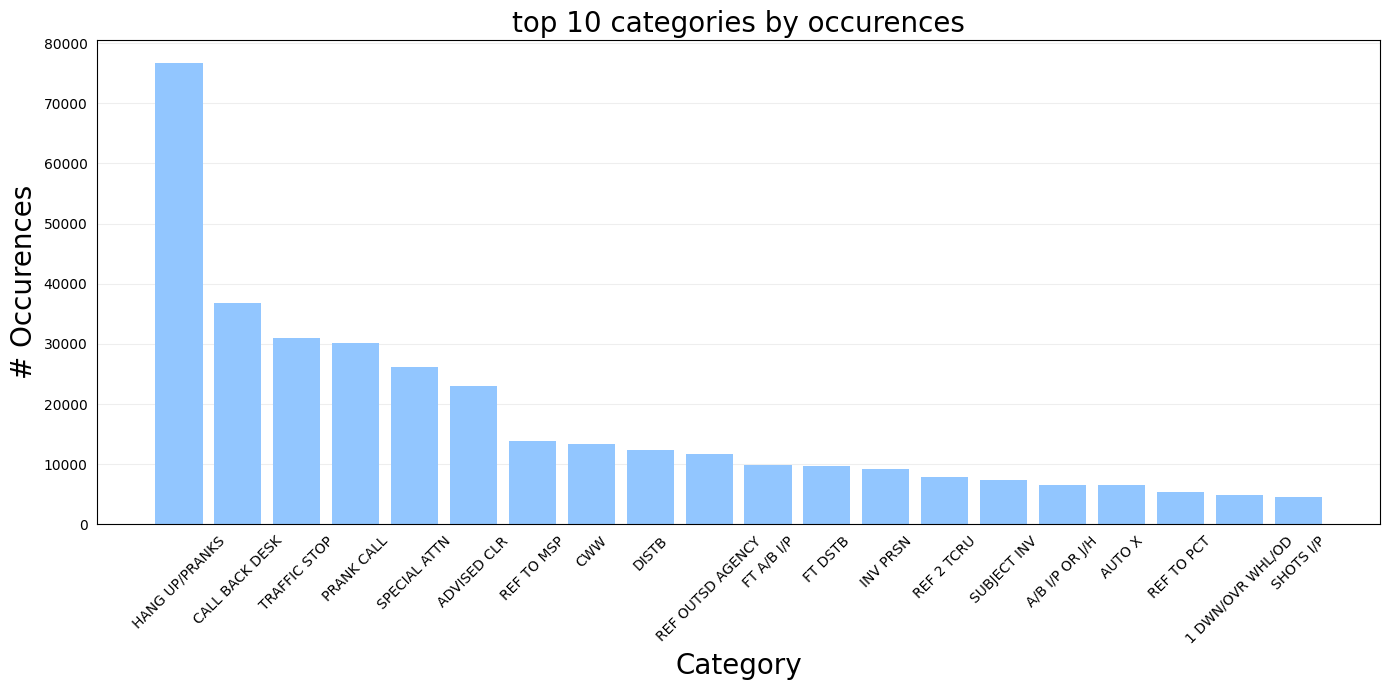

'\nmost of the calls are pranks\n'

In [6]:
x,y = np.array(list(category_count.items()))[:,0][:20], np.array(list(category_count.items()))[:,1][:20]
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x,y.astype(int))
ax.set_title("top 10 categories by occurences",size=20)
ax.set_xticklabels(x, rotation = 45)
ax.set_xlabel("Category",size = 20)
ax.set_ylabel("# Occurences",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()

plt.show()
'''
most of the calls are pranks
''' 

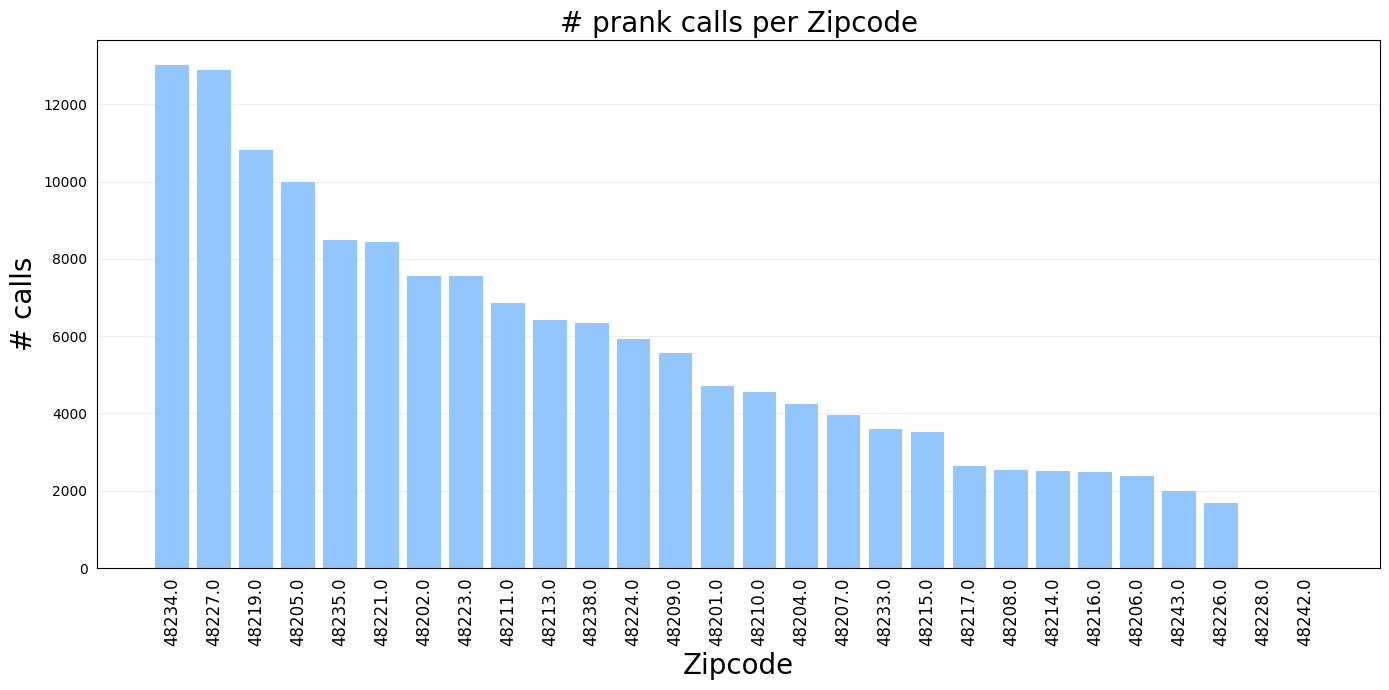

'\nremove prank calls for more clarity\n'

In [7]:
temp_df = prank_zip.reset_index().sort_values("pranks")
x,y = temp_df.values[:,0][::-1],temp_df.values[:,1][::-1]                
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int))
ax.set_title("# prank calls per Zipcode",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("# calls",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
'''
remove prank calls for more clarity
'''

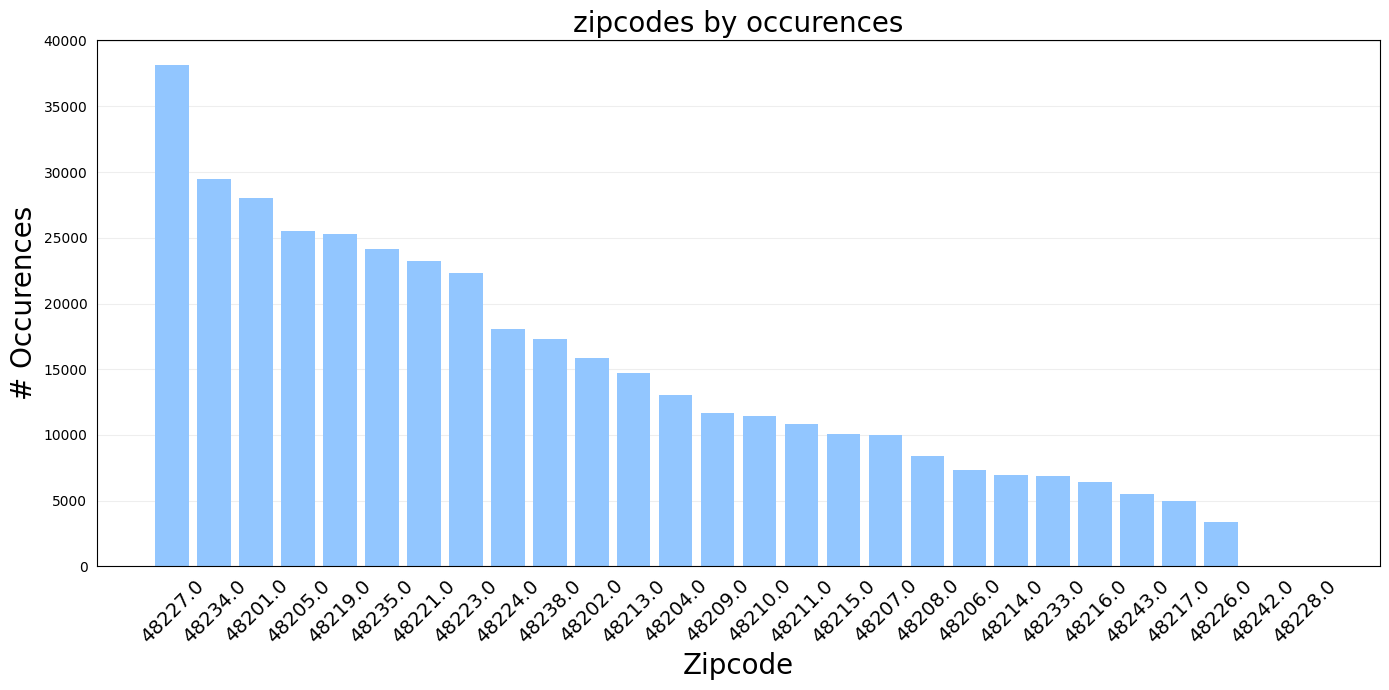

In [8]:
x,y = np.array(list(zip_count.items()))[:,0][:], np.array(list(zip_count.items()))[:,1][:]
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int))
ax.set_title("zipcodes by occurences",size=20)
ax.set_xticklabels(x, rotation = 45,size=14)
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("# Occurences",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()

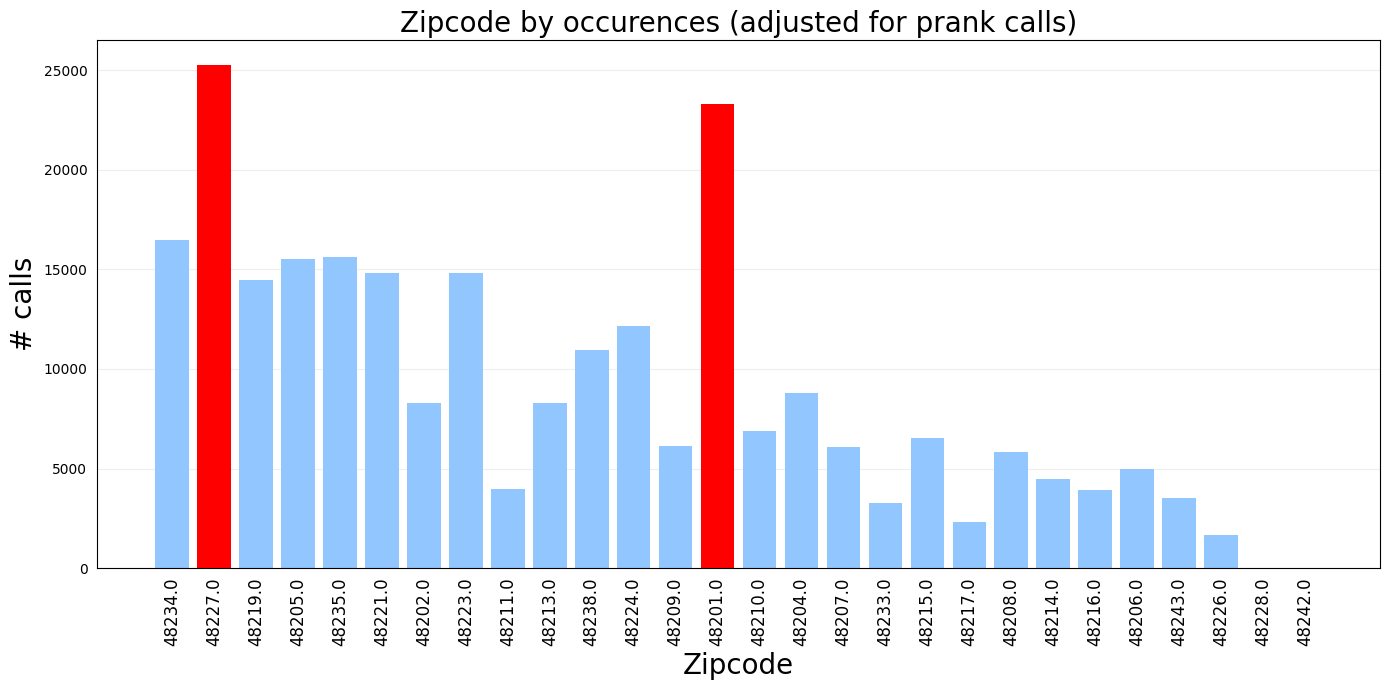

In [9]:
temp_df = prank_zip.reset_index().sort_values("pranks")
x,y = temp_df.values[:,0][::-1],- temp_df.values[:,1][::-1] + temp_df.values[:,2][::-1]                  
fig = plt.figure(figsize=(14,7))
c = np.repeat("#92C6FF",28)
c[1],c[13] = 'r','r'
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int),color=c )
ax.set_title("Zipcode by occurences (adjusted for prank calls)",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("# calls",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()


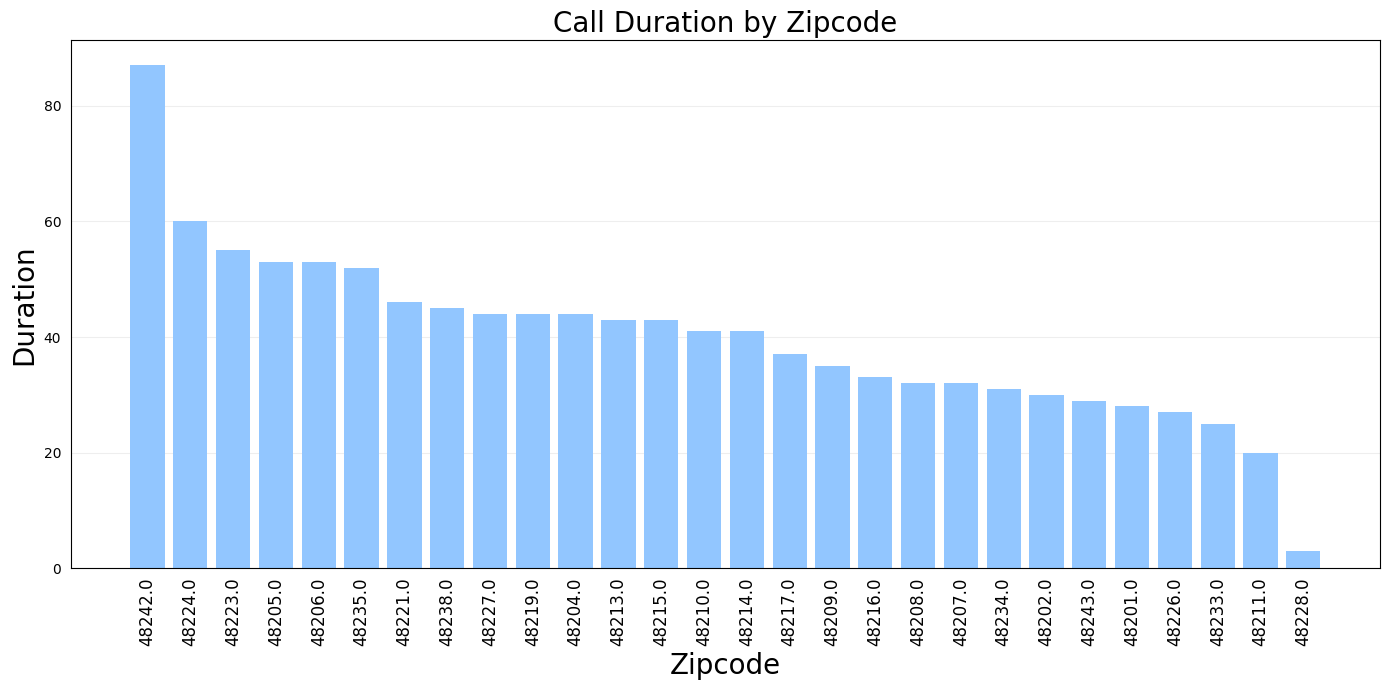

In [10]:
temp_df = zip_avgtime.sort_values("averagetime")[::-1]
x,y = temp_df.index[:], temp_df["averagetime"].values[:]
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int))
ax.set_title("Call Duration by Zipcode",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("Duration",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
# should be evenly distributed

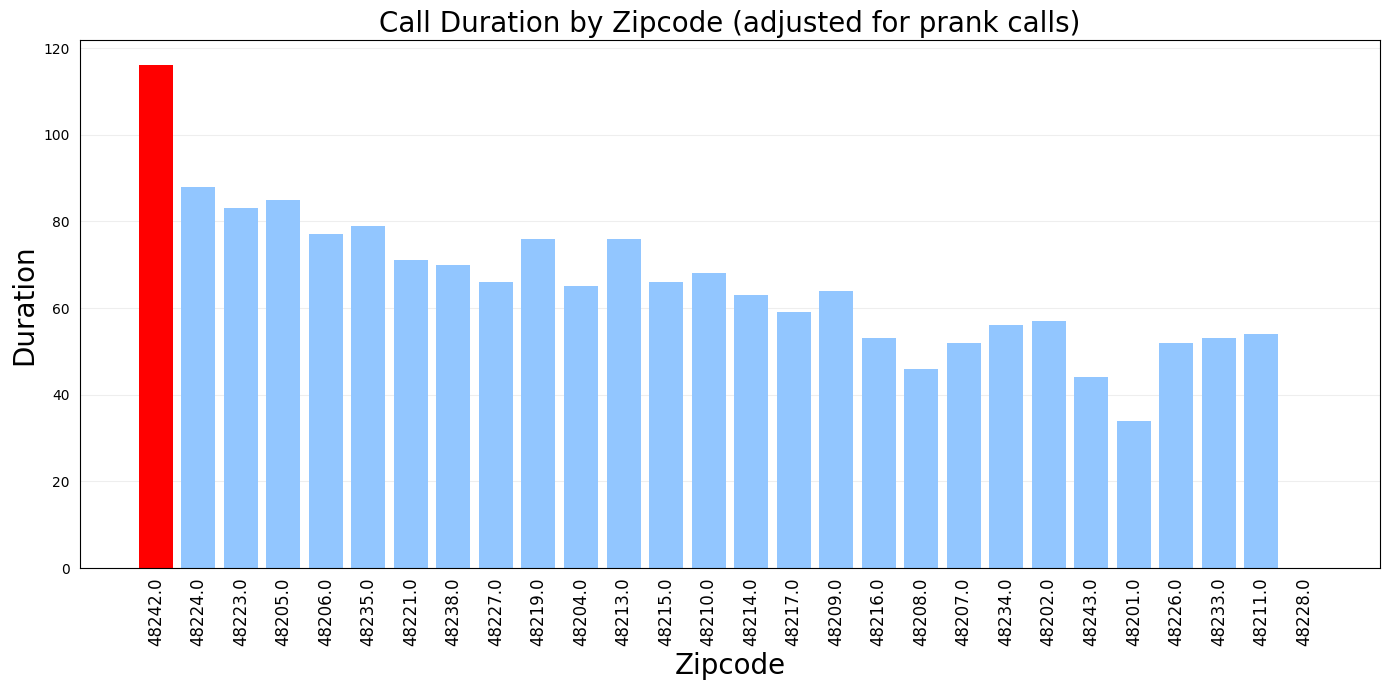

In [11]:
temp_df = zip_avgtime.sort_values("averagetime")[::-1]
x,y = temp_df.index[:], temp_df["averagetime_adjusted"].values[:]
fig = plt.figure(figsize=(14,7))
c = np.repeat("#92C6FF",28)
c[0] = 'r'
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int),color = c)
ax.set_title("Call Duration by Zipcode (adjusted for prank calls)",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("Duration",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
# should be evenly distributed

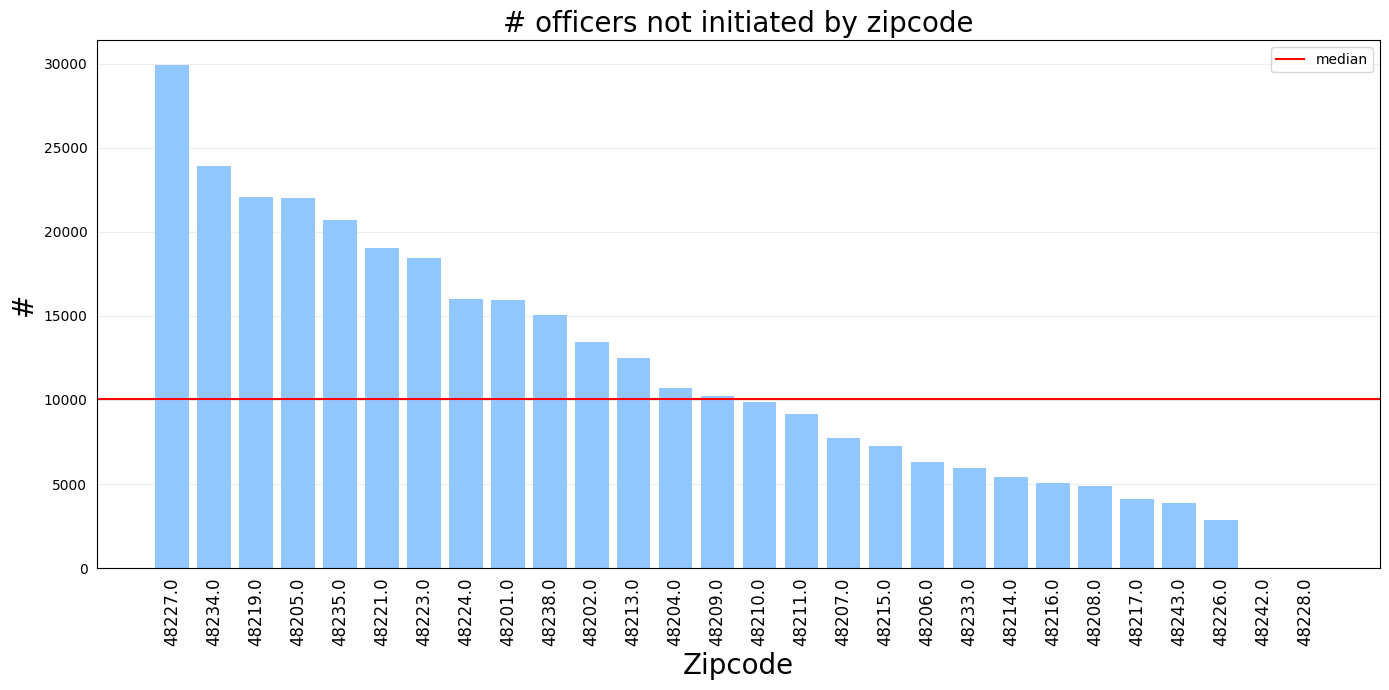

In [12]:
temp_df = officer_initiated_zip.sort_values("diff")[::-1]             
x,y = temp_df.index, temp_df["diff"].values              
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int))
ax.axhline(np.ma.median(y), c = 'r')
ax.set_title("# officers not initiated by zipcode",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
plt.legend(["median"])
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("#",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
# should be around the same value, check 48227 and everything else higher than the median

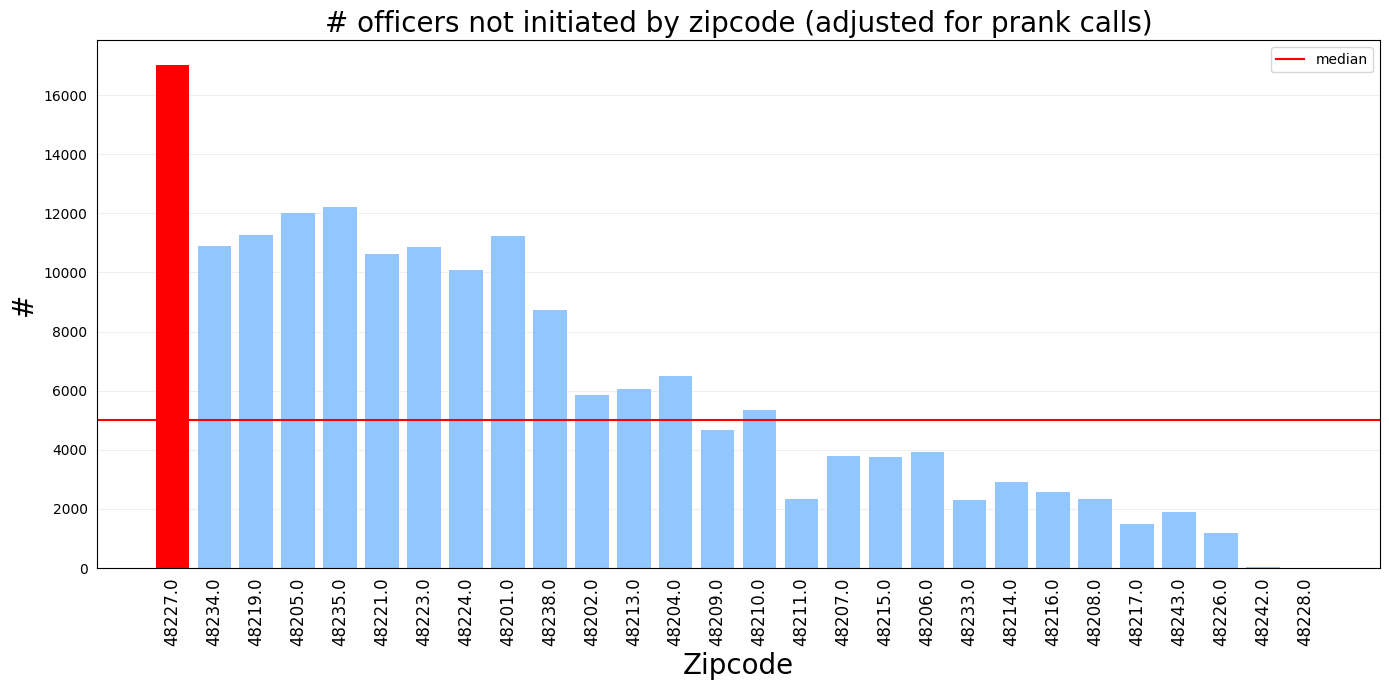

In [13]:
temp_df = officer_initiated_zip.sort_values("diff")[::-1]             
x,y = temp_df.index, temp_df["diff_adjusted"].values              
fig = plt.figure(figsize=(14,7))
c = np.repeat("#92C6FF",28)
c[0] = 'r'
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int),color = c)
ax.axhline(np.ma.median(y), c = 'r')
ax.set_title("# officers not initiated by zipcode (adjusted for prank calls)",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
plt.legend(["median"])
ax.set_xlabel("Zipcode",size = 20)
ax.set_ylabel("#",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
# should be around the same value, check 48227 and everything else higher than the median

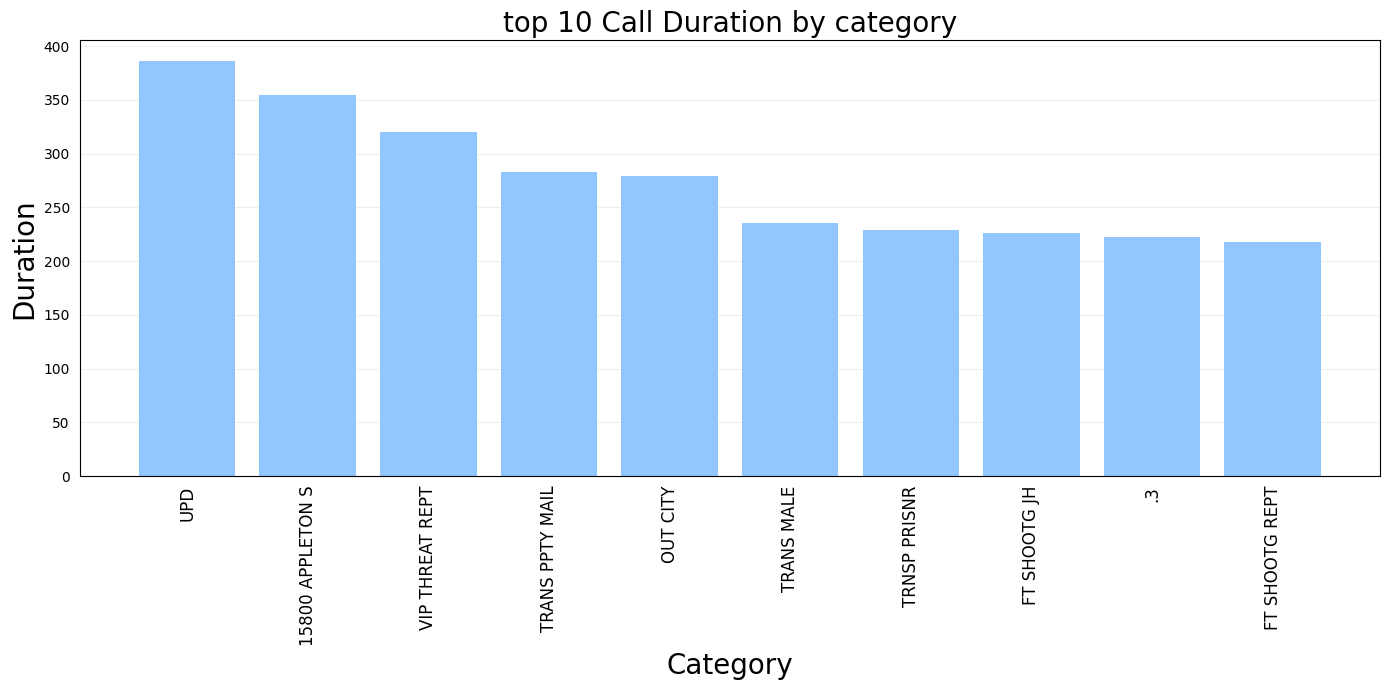

In [14]:
temp_df = category_avgtime.sort_values("averagetime")[::-1]
x,y = temp_df.index[:10], temp_df["averagetime"].values[:10]
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x,y.astype(int))
ax.set_title("top 10 Call Duration by category",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Category",size = 20)
ax.set_ylabel("Duration",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()

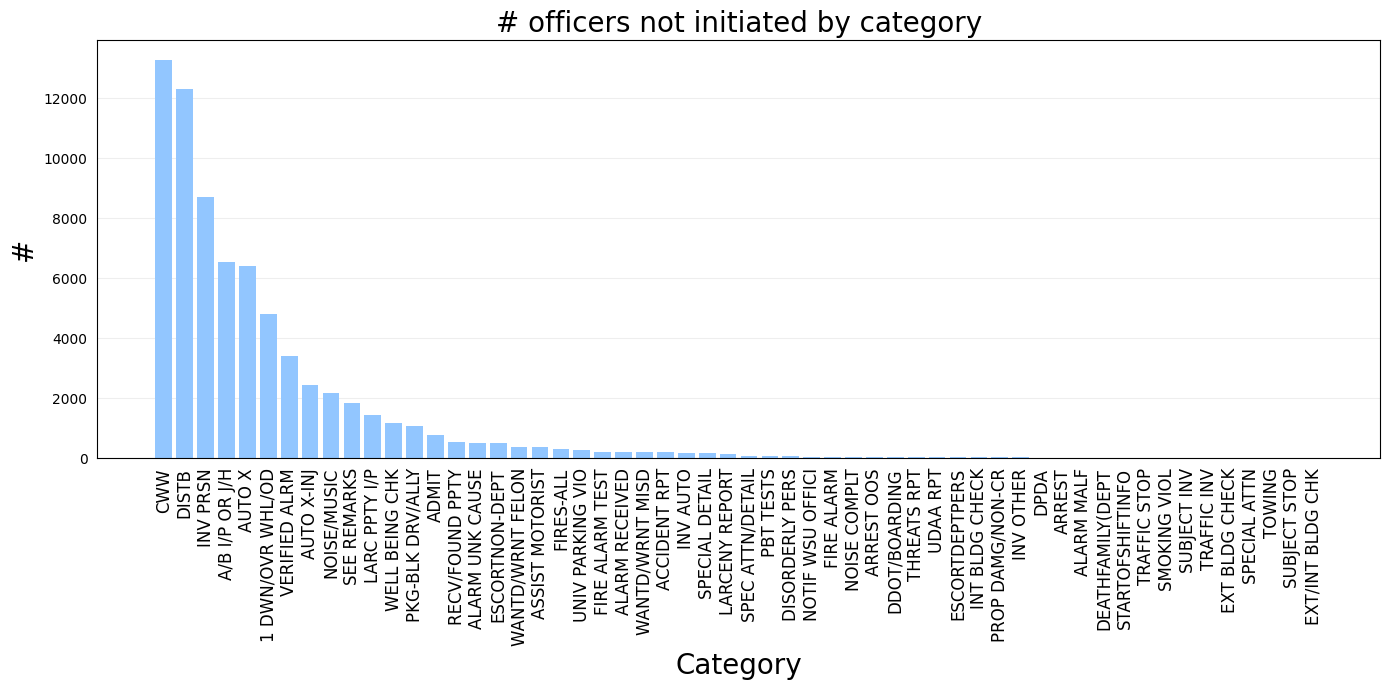

In [15]:
# using filter because there are too many categories
temp_df = officer_initiated_cat[officer_initiated_cat["total calls"] - officer_initiated_cat["diff"]> 10].sort_values("diff")[::-1]             
x,y = temp_df.index, temp_df["diff"].values              
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x,y.astype(int))
ax.set_title("# officers not initiated by category",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Category",size = 20)
ax.set_ylabel("#",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()

In [16]:
# compare prank calls per zipcode to officer initiated per zipcode
# check during which hour prank calls happen the most and see if it affects the respomse rate for that hour

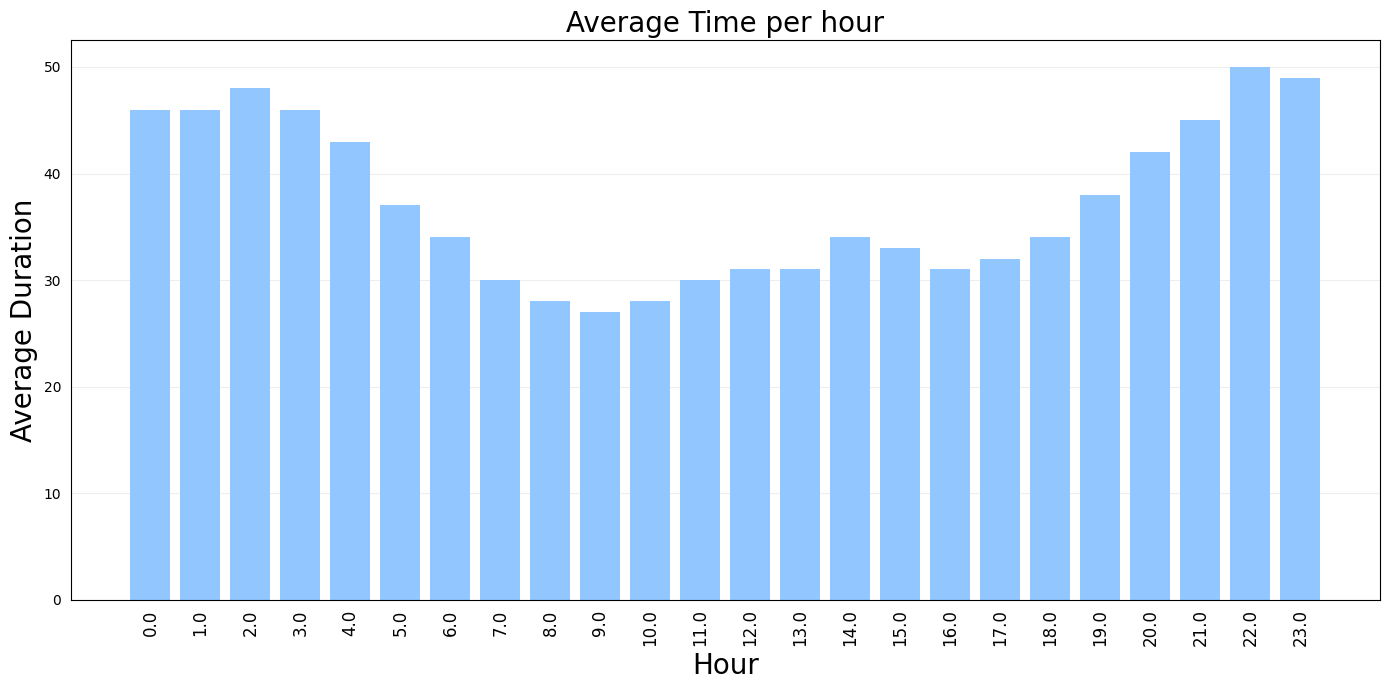

In [17]:
time_conversion = {'10AM':10, '10PM':22, '11AM':11, '11PM':23, '12AM':0, '12PM':12, '1AM':1, '1PM':13, '2AM':2,'2PM':14, '3AM':3, '3PM':15, '4AM':4, '4PM':16, '5AM':5, '5PM':17, '6AM':6, '6PM':18, '7AM':7,'7PM':19, '8AM':8, '8PM':20, '9AM':9, '9PM':21}
temp_df = hours.reset_index()
temp_df["calltime"] = temp_df["calltime"].apply(lambda x : time_conversion[x])
temp_df = temp_df.sort_values("calltime")[::-1]
x,y = temp_df.values[:,0][::-1],temp_df.values[:,1][::-1]                
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
ax.bar(x.astype(str),y.astype(int))
ax.set_title("Average Time per hour",size=20)
ax.set_xticklabels(x, rotation = 90,size = 12)
ax.set_xlabel("Hour",size = 20)
ax.set_ylabel("Average Duration",size = 20)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()